### What is this notebook for? ###

The main purpose of this notebook is parsing `param` attribute. There are two parsing modes:

1. parsing basic attributes (split on <=>)
2. parsing basic attributes + characteristics (e.g 	estores_electricos, paineis_solares, jardim, piscina).

For our service we use attributes from mode 1.

**Prerequisities:**  csv file with listings attributes `data/imovirtual_Jun_Dec.csv`. Can be obtained with sql code in the file `sql_queries/get_imovirtual_data.sql`, section 1.

**Output:**
"ads_with_featuresImo.csv"

In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
ads = pd.read_csv('../data/Imovirtual/imovirtual_Jun_Dec.csv', header=None)

/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Add headers

In [4]:
ads.columns = ["ad_id", "region_id", "category_id", "subregion_id", "district_id", "city_id", "user_id", 
               "last_update_date", "created_at_first", "valid_to", "status", "title", "description",
               "params", "map_address", "private_business", 
"images_counter", "paidads_id_index", "paidads_id_payment", "paidads_valid_to", "was_paid_for_post",
"is_paid_for_post", "export_olx_to", "brand_program_id", "user_quality_score", "updated_at",
"street_name", "street_id", "panorama", "mysql_search_rooms_num", "mysql_search_m",
"mysql_search_price", "mysql_search_price_per_m", "movie", "ad_quality_score", "user_quality_score2",
"map_lon", "map_lat", "net_ad_counted"]

Let's see the distribution of params:

In [5]:
max(ads['params'].apply(lambda x: len(x)))

1337

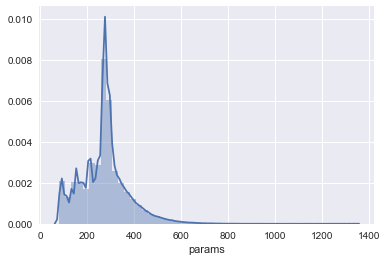

In [6]:
sns.distplot(ads['params'].apply(lambda x: len(x)))

Examples of params string:

In [7]:
ads['params'].head()

0    rooms_num<=>2<br>m<=>75<br>price_per_m<=>1320<...
1    m<=>2880<br>price_per_m<=>78.13<br>price<=>pri...
2    rooms_num<=>2<br>m<=>75<br>price_per_m<=>3333....
3    rooms_num<=>3<br>m<=>153<br>price_per_m<=>993....
4    m<=>80<br>price<=>price<br>price<=>350<br>pric...
Name: params, dtype: object

In [8]:
test = ads['params'][196]
test

'price<=>price<br>price<=>250000<br>price[currency]<=>EUR<br>m<=>310<br>gross_area<=><br>terrain_area<=><br>rooms_num<=>3<br>construction_year<=>2017<br>bathrooms_num<=>4_ou_mais<br>energy_certificate<=>a<br>condition<=>em_construcao<br>exchange<=>0<br>negotiable<=>0<br>characteristics<=>armario<->cozinha_equipada<->estores_electricos<->garagem_exterior<->jardim<->paineis_solares<->suite<br>price_per_m<=>806.45'

It looks like we can split on `<br>` to obtain attributes.
Attributes names and attributes values separated by `<=>`.  Additionaly, characteristics attribute has values separated by `<->`

In [9]:
test.split('<br>')

['price<=>price',
 'price<=>250000',
 'price[currency]<=>EUR',
 'm<=>310',
 'gross_area<=>',
 'terrain_area<=>',
 'rooms_num<=>3',
 'construction_year<=>2017',
 'bathrooms_num<=>4_ou_mais',
 'energy_certificate<=>a',
 'condition<=>em_construcao',
 'exchange<=>0',
 'negotiable<=>0',
 'characteristics<=>armario<->cozinha_equipada<->estores_electricos<->garagem_exterior<->jardim<->paineis_solares<->suite',
 'price_per_m<=>806.45']

In [10]:
for feat in test.split('<br>'):
    k, v = feat.split("<=>")
    print("k:", k, " v:", v)

k: price  v: price
k: price  v: 250000
k: price[currency]  v: EUR
k: m  v: 310
k: gross_area  v: 
k: terrain_area  v: 
k: rooms_num  v: 3
k: construction_year  v: 2017
k: bathrooms_num  v: 4_ou_mais
k: energy_certificate  v: a
k: condition  v: em_construcao
k: exchange  v: 0
k: negotiable  v: 0
k: characteristics  v: armario<->cozinha_equipada<->estores_electricos<->garagem_exterior<->jardim<->paineis_solares<->suite
k: price_per_m  v: 806.45


Here is a main function for parsing. `with_characteristics` define a mode for parsing `characteristics`. By default we will omit this field.

In [11]:
def get_features_df(ad_id, params_string, with_characteristics=False):
    f_keys = []
    f_vals = []
    features_list = params_string.split('<br>')
    for feature in features_list:
        if feature != "price<=>price":
            try:
                k, v = feature.split("<=>")
                if with_characteristics and k == 'characteristics':
                    char_k = v.split("<->")
                    for ch_k in char_k:
                        f_keys.append(ch_k)
                        f_vals.append('yes')
                f_keys.append(k)
                f_vals.append(v)
                pass
            except ValueError:
                print(feature)
    data = {'f_names': f_keys, 'f_values': f_vals}
    df_t = pd.DataFrame(data)
    df_t['ad_id'] = ad_id
    return df_t

Test our function `get_features_df` on our dataset.

In [12]:
get_features_df(ad_id = ads['ad_id'][3], params_string = ads['params'][3], with_characteristics=True)

,f_names,f_values,ad_id
0,rooms_num,3,6832984
1,m,153,6832984
2,price_per_m,993.46,6832984
3,price,152000.00,6832984
4,price[currency],EUR,6832984


In [13]:
get_features_df(ad_id = ads['ad_id'][3], params_string = ads['params'][5], with_characteristics=True)

,f_names,f_values,ad_id
0,bathrooms_num,2,6832984
1,piscina,yes,6832984
2,characteristics,piscina,6832984
3,vista_de_campo_serra,yes,6832984
4,characteristics,vista_de_campo_serra,6832984
5,construction_year,2010,6832984
6,energy_certificate,isento,6832984
7,gross_area,228,6832984
8,m,228,6832984
9,price,376200,6832984


In [14]:
get_features_df(ad_id = ads['ad_id'][3], params_string = ads['params'][196], with_characteristics=True)

,f_names,f_values,ad_id
0,price,250000,6832984
1,price[currency],EUR,6832984
2,m,310,6832984
3,gross_area,,6832984
4,terrain_area,,6832984
5,rooms_num,3,6832984
6,construction_year,2017,6832984
7,bathrooms_num,4_ou_mais,6832984
8,energy_certificate,a,6832984
9,condition,em_construcao,6832984


In [15]:
get_features_df(ad_id = ads['ad_id'][3], params_string = ads['params'][1300])

,f_names,f_values,ad_id
0,construction_year,1980,6832984
1,energy_certificate,f,6832984
2,gross_area,528,6832984
3,m,528,6832984
4,price,2500,6832984
5,price[currency],EUR,6832984
6,price_per_m,4.73,6832984
7,rooms_num,2,6832984
8,terrain_area,264,6832984


In [16]:
get_features_df(ad_id = ads['ad_id'][3], params_string = ads['params'][15000])

,f_names,f_values,ad_id
0,bathrooms_num,4_ou_mais,6832984
1,characteristics,ar_condicionado,6832984
2,characteristics,vista_de_campo_serra,6832984
3,condition,novo,6832984
4,energy_certificate,d,6832984
5,m,203,6832984
6,price,265000,6832984
7,price[currency],EUR,6832984
8,price_per_m,1305.42,6832984
9,rooms_num,3,6832984


In [17]:
len(ads)

312639

In [18]:
get_features_df(ad_id = ads['ad_id'][3], params_string = ads['params'][181379])

,f_names,f_values,ad_id
0,price,67000,6832984
1,price[currency],EUR,6832984
2,m,80,6832984
3,gross_area,,6832984
4,rooms_num,3,6832984
5,construction_year,1988,6832984
6,bathrooms_num,,6832984
7,energy_certificate,d,6832984
8,condition,usado,6832984
9,exchange,0,6832984


Lets write parsed attributes to csv file:

In [19]:
res = get_features_df(ad_id = ads['ad_id'][0], params_string = ads['params'][0])
res.to_csv("parsed_features.csv", index=None)

In [20]:
for i in range(1,len(ads)):
    if i % 10000 == 0:
        print(i)
    res = get_features_df(ad_id = ads['ad_id'][i], params_string = ads['params'][i])
    res.to_csv("parsed_features.csv", mode='a', header=False, index=None)

price[cu
terrain
cha
characte
pr
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000


* price[cu
* terrain
* cha
* characte
* pr

Five broken fields in the first 10,000 listings.

Lets see the results:

In [21]:
parsed_features = pd.read_csv("parsed_features.csv")

In [22]:
parsed_features[parsed_features['ad_id'] == 6828198]

,f_names,f_values,ad_id
3470180,bathrooms_num,4_ou_mais,6828198
3470181,characteristics,alarme,6828198
3470182,characteristics,ar_condicionado,6828198
3470183,characteristics,cozinha_equipada,6828198
3470184,characteristics,elevador,6828198
3470185,characteristics,estacionamento,6828198
3470186,characteristics,jardim,6828198
3470187,characteristics,lareira,6828198
3470188,characteristics,mobilado,6828198
3470189,characteristics,varanda,6828198


In [23]:
parsed_features['ad_id'].nunique()

312639

In [24]:
parsed_features.shape

(3542040, 3)

In [25]:
parsed_features = parsed_features.drop_duplicates()

In [26]:
parsed_features.shape

(3542010, 3)

In [27]:
parsed_features['ad_id'].nunique()

312639

In [28]:
parsed_features.head(500)

,f_names,f_values,ad_id
0,rooms_num,2,6832896
1,m,75,6832896
2,price_per_m,1320,6832896
3,price,99000.00,6832896
4,price[currency],EUR,6832896
5,m,2880,6832910
6,price_per_m,78.13,6832910
7,price,225000.00,6832910
8,price[currency],EUR,6832910
9,rooms_num,2,6832982


Let's drop all rows with name `characteristics`. In the mode 2 we have rows with e.g. `piscina`, `yes`, `ad_id`

In [29]:
parsed_features = parsed_features[parsed_features['f_names'] != 'characteristics']

In [30]:
parsed_features['ad_id'].nunique()

312639

**Reshape **

In [31]:
reshaped_features = parsed_features.pivot(index='ad_id', columns='f_names', values='f_values')

In [32]:
reshaped_features.shape

(312639, 26)

In [33]:
reshaped_features.head(30)

f_names,area_gross,bathrooms_num,condition,construction_license,construction_year,divisions_num,energy_certificate,exchange,floors,furniture,...,price,price[currency],price_per_m,purpose,register_number,rooms_num,slope,storage_space,terrain_area,type
ad_id,,,,,,,,,,,,,,,,,,,,,
6816590,None,1,usado,None,1980,None,None,None,None,None,...,85000.00,EUR,653.85,None,None,2,None,None,None,None
6816592,None,2,usado,None,1996,None,d,0,None,None,...,123000,EUR,1268.04,None,None,2,None,None,NaN,None
6816594,None,1,renovado,None,1965,None,d,None,None,None,...,999,EUR,39.96,None,None,zero,None,None,None,None
6816596,None,None,usado,None,NaN,None,b,None,None,None,...,190000.00,EUR,1328.67,None,None,3,None,None,None,None
6816598,None,None,usado,None,NaN,NaN,NaN,None,NaN,None,...,3800,EUR,3.02,None,None,None,None,None,None,None
6816600,1300,None,novo,None,2016,None,None,1,None,None,...,835000.00,EUR,92.78,None,None,9,None,None,None,None
6816602,None,2,None,None,NaN,None,None,None,None,None,...,870000.00,EUR,10116.28,None,None,2,None,None,None,None
6816604,None,1,usado,None,1951,None,e,None,None,None,...,71000.00,EUR,747.37,None,None,2,None,None,NaN,None
6816606,None,NaN,NaN,None,NaN,None,NaN,0,None,None,...,150000,EUR,757.58,None,None,more,None,None,None,None


**Attributes list**

In [34]:
for c in reshaped_features.columns:
    print(c)

area_gross
bathrooms_num
condition
construction_license
construction_year
divisions_num
energy_certificate
exchange
floors
furniture
gross_area
m
negotiable
net_area
other_characteristics
others
price
price[currency]
price_per_m
purpose
register_number
rooms_num
slope
storage_space
terrain_area
type


In [35]:
reshaped_features.to_csv("ads_with_featuresImo.csv")

Next steps described in the `2.QualityDriversDataPrep-Imovirtual`